In [13]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from utils import set_seed
set_seed(3407)
import pylab as plt
import pandas as pd

In [14]:
import pickle

class TabularRegressionData(Dataset):
    """ 
    Simple tabular data with 5 numerical features and 1 numerical response. 
    """

    def __init__(self, split, dimensions = 5):
        assert split in {'train', 'test'}
        self.split = split
        self.dimensions = dimensions
        
    def __len__(self):
        return 10000 # ...
    
    def __getitem__(self, idx):
        x = torch.randn(5)
        y = x[0] + (2 * x[2] * x[3]) - 3 * (x[4]**2)
        x, y
        return x, y


In [15]:
class CSVLoader(Dataset):
    def __init__(self, file_path, feature_cols, target_col, dimensions = 5):
        """
        Args:
            file_path (str): Path to the CSV file.
            feature_cols (list of str): List of column names to be used as features.
            target_col (str): Column name of the target variable.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(file_path)
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.dimensions = dimensions
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        features = torch.tensor(self.data_frame.loc[idx, self.feature_cols].values.astype('float32'))
        target = torch.tensor(self.data_frame.loc[idx, self.target_col], dtype = torch.float32)
        return features, target



In [16]:
# print an example instance of the dataset
train_dataset = TabularRegressionData('train')
# train_dataset = CSVLoader(
#         file_path='/home/research/dl/training_data.txt',  # Specify your CSV file path here
#         feature_cols=['x0','x1','x2','x3','x4'],  # Specify the feature column names
#         target_col='y'  # Specify the target column name
#     )
test_dataset = TabularRegressionData('test')
x, y = train_dataset[0]
print(x, y)
x1, y1 = test_dataset[0]
print(x1, y1)


tensor([ 1.0971,  0.5328, -0.3311, -0.4458,  0.6679]) tensor(0.0541)
tensor([ 0.7001, -0.8284,  2.1086, -1.0221, -1.3357]) tensor(-8.9628)


In [17]:
len(train_dataset), len(test_dataset)

(10000, 10000)

In [18]:
x1.dtype, x.dtype, y1.dtype, y.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

In [19]:
# create a GPT instance
from model_ff import ffmodel

model_config = ffmodel.get_default_config()
model_config.input_size = 5
model_config.use_dropout = False
model_config.p_drop = 0.1
model = ffmodel(model_config)

In [20]:
# create a Trainer object
from trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
train_config.batch_size = 100
train_config.eval_iters = 100
trainer = Trainer(train_config, model, train_dataset, test_dataset)

running on device cpu


In [21]:
# def batch_end_callback(trainer):
#     if trainer.iter_num % 100 == 0:
#         print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        
# #trainer.set_callback('on_batch_end', batch_end_callback)

In [22]:
trainer.run()

iter_num 100  train_loss: 31.803904 , test_loss:  30.577251
iter_num 200  train_loss: 29.76994 , test_loss:  28.672937
iter_num 300  train_loss: 28.887783 , test_loss:  29.730352
iter_num 400  train_loss: 29.572578 , test_loss:  29.258797
iter_num 500  train_loss: 30.60438 , test_loss:  29.783764
iter_num 600  train_loss: 30.131855 , test_loss:  30.104622
iter_num 700  train_loss: 29.524748 , test_loss:  30.007761
iter_num 800  train_loss: 29.074863 , test_loss:  30.061272
iter_num 900  train_loss: 29.461426 , test_loss:  30.875261
iter_num 1000  train_loss: 30.405994 , test_loss:  31.036053
iter_num 1100  train_loss: 31.308107 , test_loss:  28.924332
iter_num 1200  train_loss: 30.040394 , test_loss:  29.316622
iter_num 1300  train_loss: 29.71911 , test_loss:  29.965767
iter_num 1400  train_loss: 31.809877 , test_loss:  29.827873
iter_num 1500  train_loss: 27.92838 , test_loss:  31.38329
iter_num 1600  train_loss: 28.793568 , test_loss:  28.389343
iter_num 1700  train_loss: 28.96799 , 

In [23]:
dftrain = pd.DataFrame(trainer.train_losses)
dftrain.columns = ['batches','loss']

dftest = pd.DataFrame(trainer.test_losses)
dftest.columns = ['batches','loss']

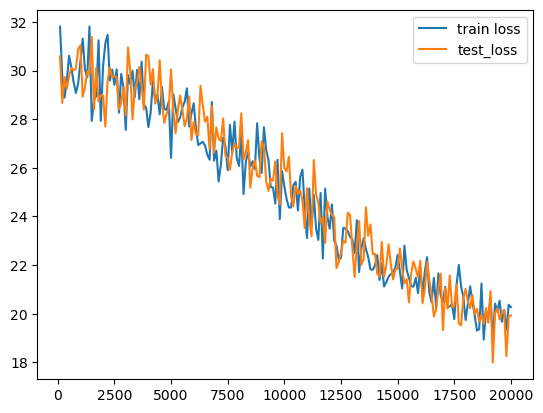

In [24]:
plt.plot(list(dftrain.batches), list(dftrain.loss))
plt.plot(list(dftest.batches), list(dftest.loss))
plt.legend(['train loss','test_loss'])